In [1]:
import argparse
import logging
import os

# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/home/yl826/3DPathLoss/nc_raytracing/Pytorch-UNet-master')
    
    
    

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_loading_rt import RTDataset, RTDataset_data_aug
from unet.unet_model_rt import UNet
from utils.utils import plot_img_and_mask

import random

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split

from scipy import ndimage, datasets

dir_checkpoint = Path('./checkpoints/')


In [241]:
from decimal import Decimal
import json
import psycopg2



def rows_to_dict(rowsss, cccursor):
    columns = [desc[0] for desc in cccursor.description]
    result = []
    for rrr in rowsss:
        result.append(dict(zip(columns, rrr)))
    return result



def combine_dicts_to_dict_of_lists(dict_list):
    result = {}
    for dictionary in dict_list:
        for key, value in dictionary.items():
            if key not in result:
                result[key] = []
            result[key].append(value)
    for key in result.keys():
        if isinstance(result[key][0], Decimal):
            for iii, item in enumerate(result[key]):
                result[key][iii] = float(item)
    return result


def get_data_dict():
    connection = psycopg2.connect(database=db_name, user=db_user,
                                  password=db_password, host=db_host, port=db_port)
    cursor = connection.cursor()

    cursor.execute("SELECT latitude as latitude, longitude as longitude, "
                   "rssi as rssi, azimuth as azimuth FROM \"SigCapDetails\" "
                   "WHERE \"mPci\"=20 and \"operatorID\" like \'runxi%\'" )
    rows = cursor.fetchall()

    df_ret = combine_dicts_to_dict_of_lists(rows_to_dict(rows, cursor))
    cursor.close()
    connection.close()
    return df_ret


with open("SQLpwd.json", 'r') as file:
    credential = json.load(file)
db_host = credential['db_host']
db_port = credential['db_port']
db_name = credential['db_name']
db_user = credential['db_user']
db_password = credential['db_password']

df_SigCapDetails = get_data_dict()
print(df_SigCapDetails['azimuth'][0:5])
print(df_SigCapDetails['latitude'][0:5])
print(df_SigCapDetails['longitude'][0:5])
print(len(df_SigCapDetails["azimuth"]))

[63.39279568701839, 66.84852306739718, 68.23022935535573, 68.33971045756186, 73.68140333194292]
[36.00307172, 36.00296746, 36.00298388, 36.00297698, 36.00313857]
[-78.93744816, -78.93724173, -78.93729169, -78.93726835, -78.93759875]
907


In [242]:
# import geopy.distance

top_left = (36.005429554748495, -78.93998431793196)
#top_left = (36.00537843896, -78.93990009673)
bs = (36.00307128210248, -78.93706070613855)

# print(geopy.distance.geodesic(top_left, bs).m)


# def get_d(x,y):
#     return geopy.distance.geodesic(top_left, (x,y)).m

import pymap3d as pm

# The local coordinate origin (Zermatt, Switzerland)
lat0 = 46.017 # deg
lon0 = 7.750  # deg
h0 = 1673     # meters

# The point of interest
lat = 45.976  # deg
lon = 7.658   # deg
h = 4531      # meters

bs_h =24

pm.geodetic2ned(top_left[0], top_left[1], 1 , bs[0], bs[1], 1)



def gps2local(x,y):
    res = pm.geodetic2ned(top_left[0], top_left[1], 1 , x, y, 1)
    return  res[0], -1 * res[1]

gps2local(bs[0], bs[1])

(261.67575614021484, 263.58559168127186)

In [243]:
def uma_los(d3d, d2d, dbp, fc, h_b, h_t):
    # 38.901 UMa LOS
    PL1 = 28+22*np.log10(d3d)+20*np.log10(fc)
    PL2 = 28+40*np.log10(d3d)+20*np.log10(fc) - 9*np.log10(dbp**2+(h_b - h_t)**2)
    PL = np.zeros((d3d.shape))
    PL = PL2 # Default pathloss
    PL[(np.greater_equal(d2d,10) & np.less_equal(d2d,dbp))] = PL1[(np.greater_equal(d2d,10) & np.less_equal(d2d,dbp))] # Overwrite if distance is greater than 10 meters or smaller than dbp
    return PL



def uma_nlos(d3d, d2d, dbp, fc, h_b, h_t):
    # 38901 UMa NLOS
    PL_nlos = 13.54+39.08*np.log10(d3d)+20*np.log10(fc)-0.6*(h_t-1.5)
    PL = np.zeros((d3d.shape))
    PL = np.maximum(RTDataset.uma_los(d3d, d2d, dbp, fc, h_b, h_t), PL_nlos)
    return PL


def pathloss_38901(distance, frequency, h_bs=30, h_ut=1.5):
    #print(distance)
    """
        Simple path loss model for computing RSRP based on distance.

        fc: frequency in GHz
        h_b: height of basestation
        h_t: height of UT
    """
    # Constants
    fc = frequency
    h_b =  h_bs # 30 meters
    h_t =  h_ut # 1.5

    # 2D distance 
    d2d = distance

    # 3D distance
    h_e = h_b - h_t # effective height
    d3d = np.sqrt(d2d**2+h_e**2)

    # Breakpoint distance
    dbp =  4*h_b*h_t*fc*10e8/speed_of_light

    loss = RTDataset.uma_nlos(d3d, d2d, dbp, fc, h_b, h_t)
    return loss

0
907
too large
too large
Building!
Building and no able to move right!
Building!
Building and no able to move right!
Building!
Building and no able to move right!
too large
too large
too large
too large
too large
too large
too large
Building!
Building and no able to move right!
too large
too large
too large
Building!
Building and no able to move right!
too large
too large
Building!
Building and no able to move right!
too large
Building!
Building and no able to move right!
too large
too large
too large
Building!
Building!
Building and no able to move right!
too large
Building!
Building!
Building and no able to move right!
too large
Building!
Building and no able to move right!
Building!
Building and no able to move right!
Building!
Building and no able to move right!
Building!
Building and no able to move right!
Building!
Building and no able to move right!
Building!
Building and no able to move right!
Building!
Building and no able to move right!
too large
too large
Building!
Building

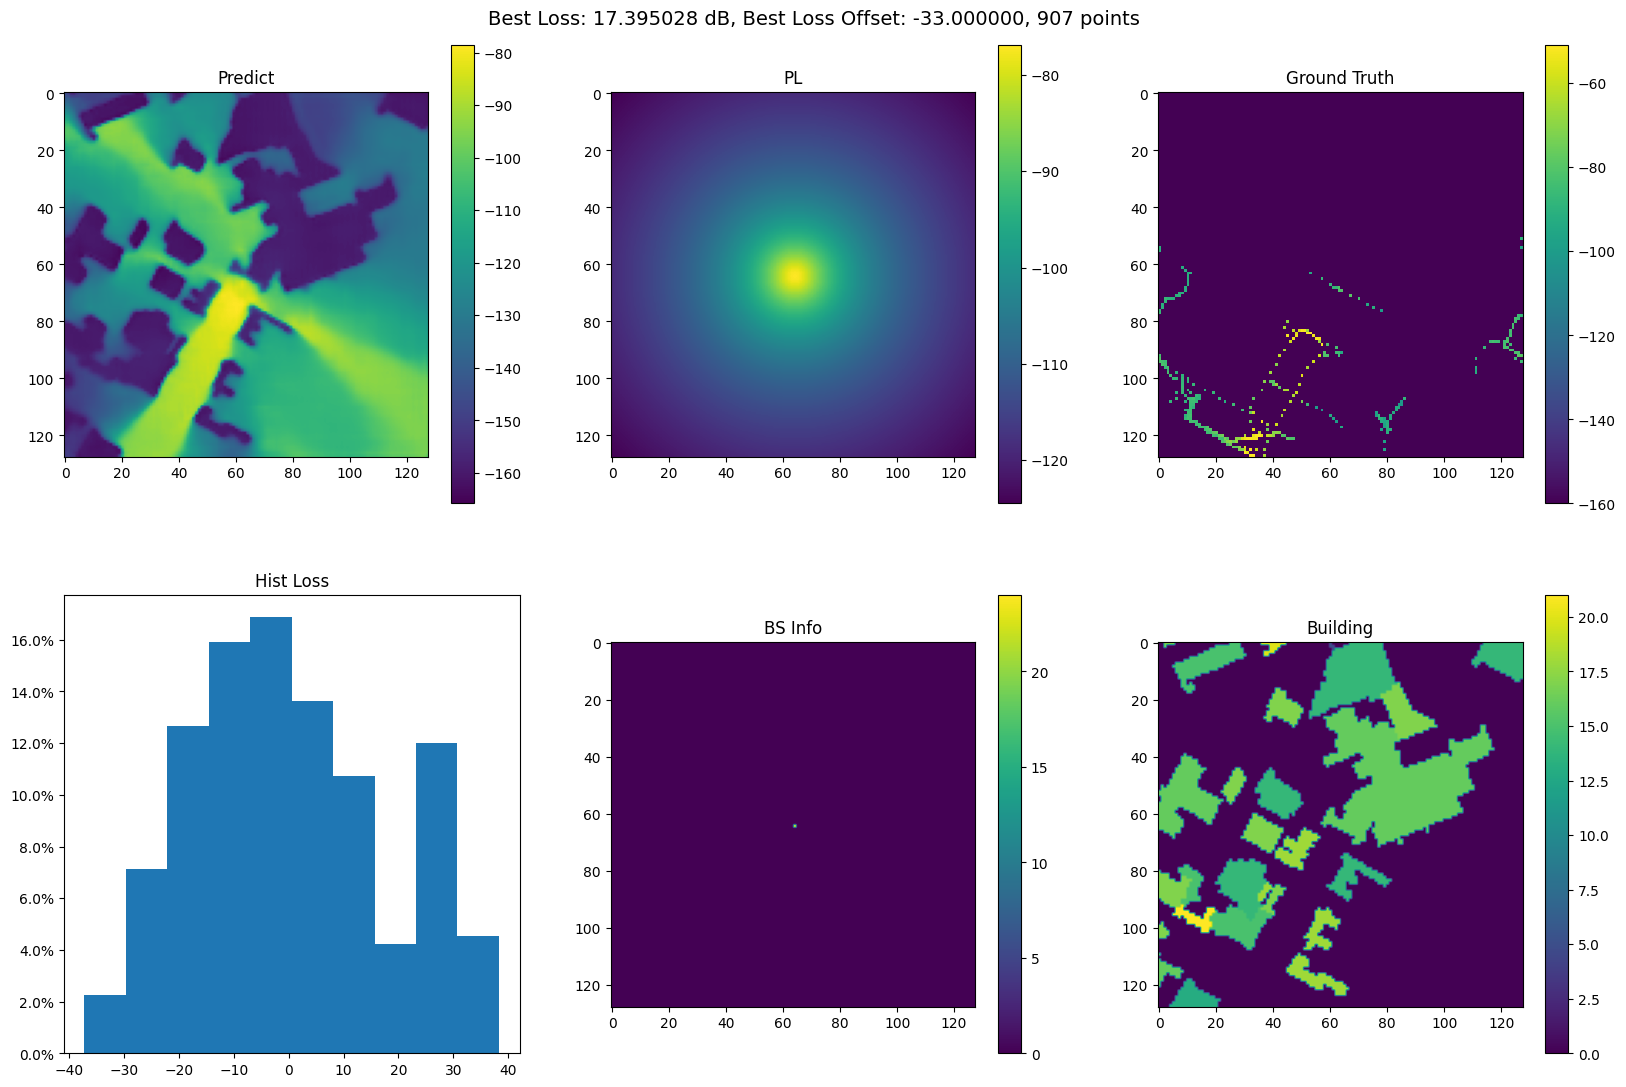

[20.28905363445125, 19.58707015218292, 18.91192578537234, 18.266596745872704, 17.654352903497294, 17.07875277080031, 16.543621609883843, 16.053007062102463, 15.611106799353067, 15.222163948194224, 14.890328909416342, 14.619490921215286, 14.413089001334594, 14.273918674466668, 14.203956283028486, 14.204224507345709, 14.274719388484543, 14.414410615244474, 14.621315028059847, 14.892631497309832, 15.224916836540055, 15.614279120230206, 16.05656663827461, 16.54753613001794, 17.082990714132734, 17.658884208919922, 18.27139324925545, 18.916961464089145, 19.59232122028244, 20.294498529493797, 21.02080612936911, 21.76882886361638, 22.53640454594108, 23.321602638395373, 24.122702364952932, 24.938171327364845, 25.766645278691183, 26.606909416217338, 27.457881353951738, 28.318595802274285, 29.18819089936002, 30.065896090793277, 30.951021429143097, 31.84294815610156, 32.74112043038642, 33.645038071043444, 34.55425019540809, 35.46834964206476, 36.38696808057319, 37.309771720844765, 38.2364575454688

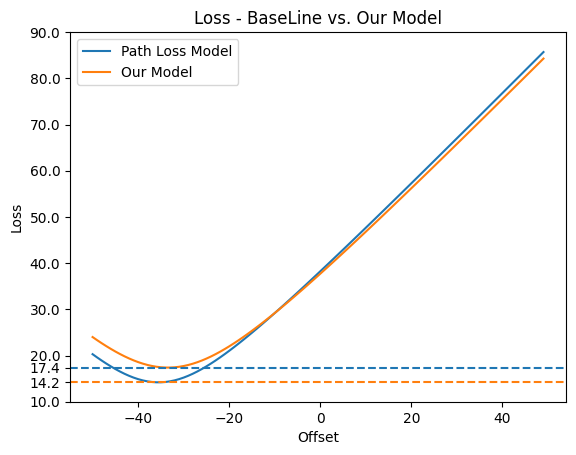

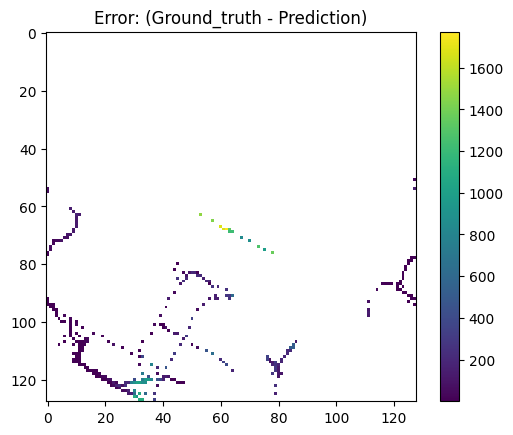

In [244]:
import matplotlib.ticker as mtick
import math

# 1.Create the Modle
net = UNet(n_channels=2, n_classes=1, bilinear=False, pathloss=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)


# 2.Load state dict
state_dict = torch.load("../Pytorch-UNet-master/checkpoints/checkpoint_epoch32.pth", map_location=device)
net.load_state_dict(state_dict)
logging.info('Model loaded!')



# 3.Load data

name = "0_78d03890-be26-47f8-8b81-8485f0d19a83.npy"


name_splited = name.split("_")
file_name_id_part = name_splited[0]
tx_height = 24
tx_x = 256
tx_y = 256
tx_position = [tx_x // 4, tx_y // 4]
distance = np.arange(0, 1450,1)
path_loss_res =  RTDataset.pathloss_38901(distance,3.64, h_bs=int(tx_height), h_ut=2)


building_height_arr = np.load("/home/yl826/3DPathLoss/nc_raytracing/POC/0_78d03890-be26-47f8-8b81-8485f0d19a83.npy")
building_height_arr = building_height_arr[0:512, 0:512]
building_height_arr = building_height_arr[::4, ::4]



measurement = np.empty([len(df_SigCapDetails["latitude"]), 3])
measurement[:, 0] = df_SigCapDetails["latitude"]
measurement[:, 1] = df_SigCapDetails["longitude"]
measurement[:, 2] = df_SigCapDetails["rssi"]



for idx, point in enumerate(measurement):
    
    row, col = gps2local(measurement[idx,0], measurement[idx,1])
    measurement[idx, 0] = row
    measurement[idx, 1] = col
    


ground_truth_list, sparse_ss_arr = np.split(np.random.permutation(measurement), [1437])
ground_truth_list = measurement

sparse_ss_arr[:,0] = sparse_ss_arr[:,0]/4
sparse_ss_arr[:,1] = sparse_ss_arr[:,1]/4

print(len(sparse_ss_arr))
print(len(ground_truth_list))
ground_truth_arr = np.zeros([128,128])

ground_truth_arr_num = np.zeros((128,128))

for point in ground_truth_list:
    row = int(point[0]/4)
    col = int(point[1]/4)
    if row >=128 or col >= 128:
        print("too large")
        continue
    if building_height_arr[row,col] != 0:
        print("Building!")
        if building_height_arr[row,col+1] == 0:
            col = col + 1
        else:
            print("Building and no able to move right!")
            continue
    ground_truth_arr_num[row][col] +=1
    ground_truth_arr[row][col] += 10 ** (point[2]/10)
    
for row in range(128):
    for col in range(128):
        if ground_truth_arr_num[row][col] != 0:
            ground_truth_arr[row][col] = 10 * np.log10(ground_truth_arr[row][col]/ground_truth_arr_num[row][col])
        else:
            ground_truth_arr[row][col] = -160



 # Construct the TX position channel
tx_position_channel = np.full((128, 128), 0, dtype=int)
tx_position_channel[tx_position[1]][tx_position[0]] = tx_height






# Construct the Path Loss Model (3GPP TR 308.91 nLos UMa)
path_loss_heat_map = np.full((128, 128), 0, dtype=float)



for row in range(path_loss_heat_map.shape[0]):
    for col in range(path_loss_heat_map.shape[1]):
        # Compute the distance between pixel and tx
        dist = math.sqrt((tx_position[1]*4 - row*4)**2 + (tx_position[0]*4 - col*4)**2)
        path_loss_heat_map[row][col] =  -1 * path_loss_res[int(dist)]





# Since right now GT.size is 100*100 and other two size is 1000 * 1000, just check the input.
# assert building_height_arr.shape == terrain_height_aimport loggin
combined_input = np.zeros((3, 128, 128), dtype=float)







# Combine all the channels together
combined_input[0,:, :] = building_height_arr 
combined_input[1,:, :] = tx_position_channel
combined_input[2,:, :] = path_loss_heat_map 





batch = {
            'combined_input': torch.as_tensor(combined_input.copy()).float().contiguous(),
            'ground_truth': torch.as_tensor(ground_truth_arr.copy()).long().contiguous(),
            'file_name': name,
            'sparse_ss': torch.as_tensor(sparse_ss_arr.copy()).float().contiguous()
        }




# 4. Eval
images, ground_truth = batch['combined_input'], batch['ground_truth']
sparse_ss = batch['sparse_ss']

# Since we directly load the data by manual, add batch dimension to the front of data
images = images[None,:, :, :]
sparse_ss = sparse_ss[None,:, :]


net.eval()
print(images.shape)
images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
ground_truth = ground_truth.to(device=device, dtype=torch.long)
sparse_ss = sparse_ss.to(device=device, dtype=torch.float32)

with torch.no_grad():
    output = net(images, sparse_ss).cpu()

output = output.squeeze().cpu().numpy()
print(output.shape)
print(np.sum(ground_truth_arr > -150))     




best_offset = 0
loss_offset = []
for offset in range(-50,50):
    loss  = 0
    count = 0
    for row in range(128):
        for col in range(128):
            if ground_truth_arr[row,col] != -160:

                loss += (ground_truth_arr[row,col] - output[row,col] + offset) ** 2
                count += 1

                
    loss_offset.append(math.sqrt(loss/count))
    if math.sqrt(loss/count) <= min(loss_offset):
        best_offset = offset
print(loss_offset)
hist_data = []  
for row in range(128):
    for col in range(128):
        if ground_truth_arr[row,col] != -160:
            hist_data.append(ground_truth_arr[row,col] - output[row,col] + best_offset)


            
print("Best Loss: %f, Best Loss Offset: %f"%(min(loss_offset),best_offset))



import torch.nn as nn



# Create a figure with two subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))






# vmin = min([np.min(output),np.min(ground_truth[0].cpu().numpy())])
# vmax = max([np.max(output),np.max(ground_truth[0].cpu().numpy())])


#Plot the first image in the left subplot
im = axes[0,0].imshow(output)
axes[0,0].set_title('Predict')
fig.colorbar(im)

# Plot the second image in the right subplot
im = axes[0,1].imshow(path_loss_heat_map)
axes[0,1].set_title('PL')
fig.colorbar(im)

ground_truth_arr_copy = ground_truth_arr.copy()
ground_truth_arr_copy[ground_truth_arr_copy == -160] = np.nan
#         # Plot the second image in the right subplot
im = axes[0,2].imshow(ground_truth_arr,  interpolation='nearest')
axes[0,2].set_title('Ground Truth')
fig.colorbar(im)



im = axes[1,1].imshow(tx_position_channel)
axes[1,1].set_title('BS Info')
fig.colorbar(im)






# data = ((ground_truth[0].cpu() - output)).flatten()
# data = data / len(data) * 1000
im = axes[1,0].hist(hist_data, weights=np.ones(len(hist_data)) / len(hist_data))
axes[1,0,].yaxis.set_major_formatter(mtick.PercentFormatter(1))
axes[1,0].set_title('Hist Loss')


im = axes[1,2].imshow(images[0,0,:,:].cpu())
axes[1,2].set_title('Building')
fig.colorbar(im)





# Set spacing between subplots
#plt.subplots_adjust(wspace=0.4)

# Display the figure
plt.subplots_adjust(top=0.95)
plt.suptitle("Best Loss: %f dB, Best Loss Offset: %f, %d points"%(min(loss_offset),best_offset, len(ground_truth_list)), fontsize=14)

plt.show()






best_offset_pl = 0
loss_offset_pl = []
for offset in range(-50,50):
    loss  = 0
    count = 0
    for row in range(128):
        for col in range(128):
            if ground_truth_arr[row,col] != -160:

                loss += (ground_truth_arr[row,col] - path_loss_heat_map[row,col] + offset) ** 2
                count += 1

                
    loss_offset_pl.append(math.sqrt(loss/count))
    if math.sqrt(loss/count) <= min(loss_offset_pl):
        best_offset_pl = offset
print(loss_offset_pl)
hist_data_pl = []  
for row in range(128):
    for col in range(128):
        if ground_truth_arr[row,col] != -160:
            hist_data_pl.append(ground_truth_arr[row,col] - path_loss_heat_map[row,col] + best_offset)
            
            
            
plt.plot(range(-50,50),loss_offset_pl, label ='Path Loss Model')
plt.plot(range(-50,50), loss_offset,label ='Our Model')

plt.axhline(np.min(loss_offset), color='#1f77b4', linestyle='--', label='')
plt.axhline(np.min(loss_offset_pl), color='#ff7f0e', linestyle='--', label='')
#plt.yticks([np.min(loss_offset),np.min(loss_offset_pl) ], [f'Axis Line at {np.min(loss_offset_pl):.2f}', f'Axis Line at {np.min(loss_offset_pl):.2f}'], color='red')
plt.yticks(list(plt.yticks()[0]) + [np.min(loss_offset), np.min(loss_offset_pl)])
plt.xlabel('Offset')
plt.ylabel('Loss')
plt.title('Loss - BaseLine vs. Our Model')
plt.legend()
plt.show()

error_map = np.zeros((128,128))
for row in range(128):
    for col in range(128):
        error_map[row][col] = building_height_arr[row,col]
        if ground_truth_arr[row,col] != -160:
            error_map[row][col] = (ground_truth_arr[row][col] - path_loss_heat_map[row,col] + best_offset_pl)**2
            
        else:
            error_map[row][col] = np.nan


plt.imshow(error_map, interpolation='nearest')

plt.title('Error: (Ground_truth - Prediction)')
plt.colorbar()
plt.show()
# if not args.no_save:
#     out_filename = out_files[i]
#     result = mask_to_image(mask, mask_values)
#     result.save(out_filename)
#     logging.info(f'Mask saved to {out_filename}')
#
# if args.viz:
#     logging.info(f'Visualizing results for image {filename}, close to continue...')
#     plot_img_and_mask(img, mask)

/tmp/ipykernel_2584883/251045029.py:2: RuntimeWarning: divide by zero encountered in log10
  cm_2D_db = 10 * np.log10(cm_2D)


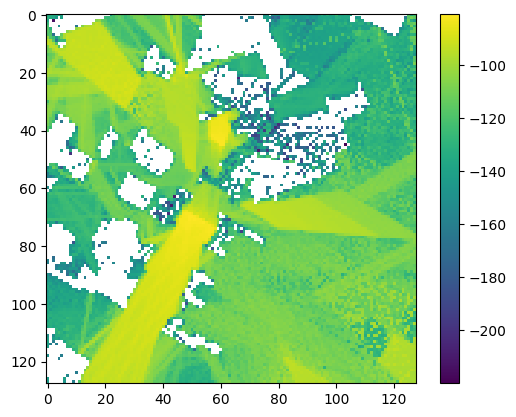

In [254]:

cm_2D = np.load("Duke_Pred_cm.npy")
cm_2D_db = 10 * np.log10(cm_2D)
# cm_2D_db[np.isinf(cm_2D_db)] = -200
# from scipy.ndimage.filters import gaussian_filter

# cm_2D_db = gaussian_filter(cm_2D_db, sigma=1)


plt.imshow(cm_2D_db, interpolation='nearest')
plt.colorbar()

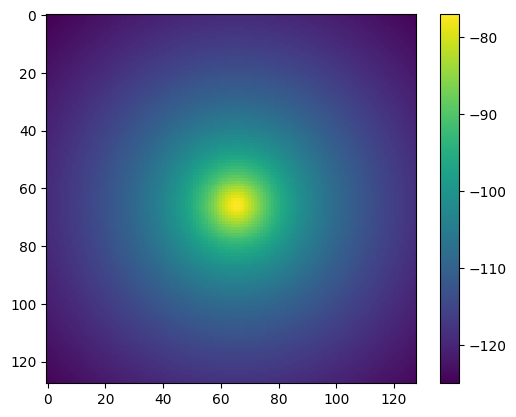

[16.74120634 27.        ]


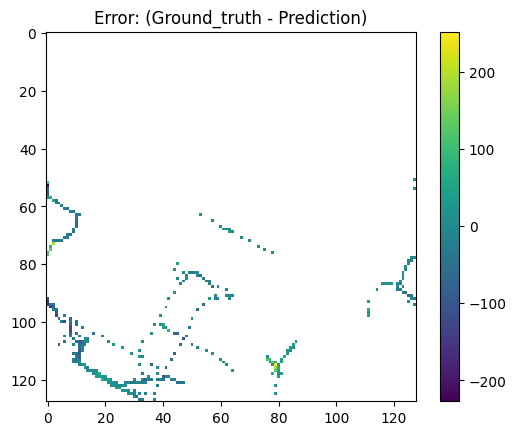

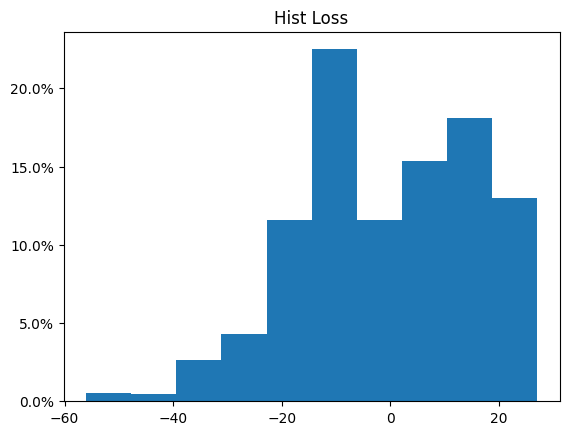

[16.02196349 31.        ]


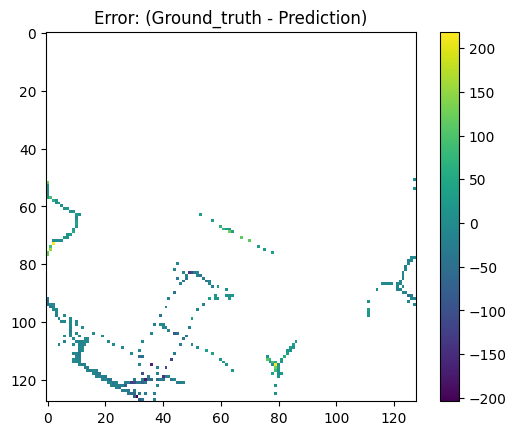

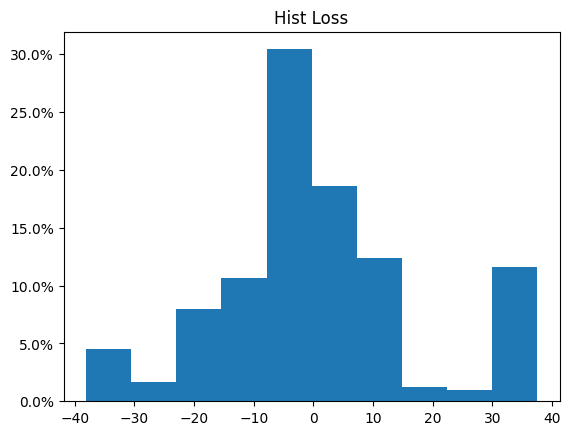

18.660324129390396
14.533472360311466


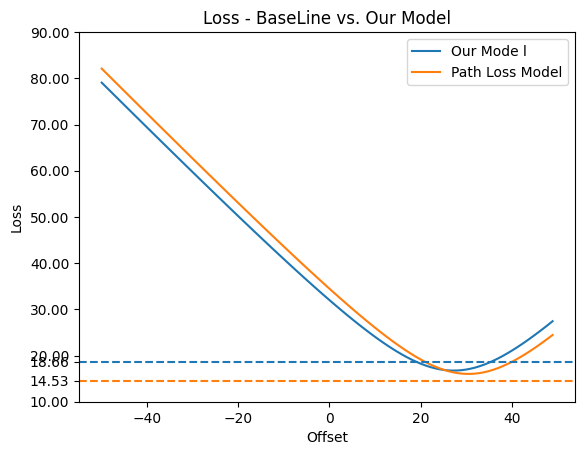

ValueError: x must have 2 or fewer dimensions

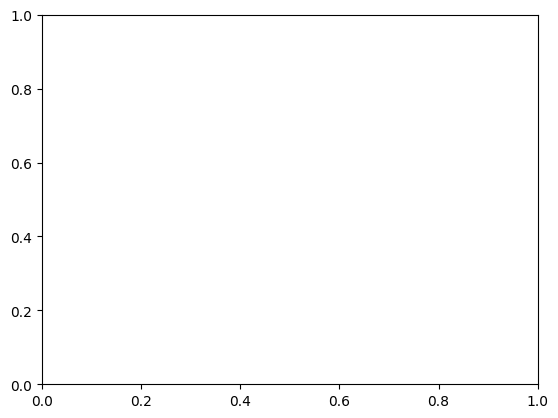

In [255]:


building_height_arr = np.load("/home/yl826/3DPathLoss/nc_raytracing/POC/0_78d03890-be26-47f8-8b81-8485f0d19a83.npy")
building_height_arr = building_height_arr[0:512, 0:512]
building_height_arr = building_height_arr[::4, ::4]


def get_best_offset(ground_truth, predict, offset_range=(-50,50)):

    assert ground_truth.shape == predict.shape , "ground_truth and predict shape mismatch "
    best_offset = 0
    loss_offset = []
    for offset in range(*offset_range):
        loss  = 0
        count = 0
        for row in range(ground_truth.shape[0]):
            for col in range(ground_truth.shape[0]):
                if ground_truth[row,col] != -160 and ~np.isinf(predict[row,col]):

                    loss += (ground_truth[row,col] - predict[row,col] + offset) ** 2
                    count += 1


        loss_offset.append(math.sqrt(loss/count))
        if math.sqrt(loss/count) <= min(loss_offset):
            best_offset = offset
    return best_offset, loss_offset
def get_pl_cm(size, resolution, tx_position, freq=3.64, bs_height=24, ue_height=2 ):
    
    assert size % resolution == 0 , "Size % reslution != 0"
    
    img_size = int(size/resolution)
    distance = np.arange(0, 2500,1)
    path_loss_res =  RTDataset.pathloss_38901(distance, freq, h_bs=int(tx_height), h_ut=ue_height)
    # Construct the Path Loss Model (3GPP TR 308.91 nLos UMa)
    path_loss_heat_map = np.full((img_size, img_size), 0, dtype=float)



    for row in range(path_loss_heat_map.shape[0]):
        for col in range(path_loss_heat_map.shape[1]):
            # Compute the distance between pixel and tx
            dist = math.sqrt((tx_position[1]*resolution - row*resolution)**2 + (tx_position[0]*resolution - col*resolution)**2)
            path_loss_heat_map[row][col] =  -1 * path_loss_res[int(dist)]
    return path_loss_heat_map


pl_cm = get_pl_cm(512, 4 ,(130.83/2,131.79/2),  3.64, 24, 2)
plt.imshow(pl_cm, interpolation='nearest')
plt.colorbar()
plt.show()

def measurement2map(measurement, size:int, reslution:int, predict,ground_truth, offset_range=(-50,50)):
    
    res = measurement.copy()
    
    # Create a new column (example: an array of ones)
    #new_column = np.zeros((res.shape[0], 1))
    
    # Stack the new column horizontally to the original matrix
    res = np.hstack((res, res[:,-1].reshape(-1, 1)))
    
    assert size % reslution == 0 , "Size % reslution != 0"
    img_size =int(size / reslution)
    
    ground_truth_arr = np.zeros([img_size,img_size])
    ground_truth_arr_num = np.zeros((img_size,img_size))
    
    
    for point in res:
        row = int(point[0]/reslution)
        col = int(point[1]/reslution)
        if row >=img_size or col >= img_size:
            #print("too large")
            continue
        if np.isnan(ground_truth[row,col]) or np.isinf(ground_truth[row,col]) :
            #print("Nan or Inf value on prediction map!")
            continue
            
        
        point[3] = predict[row,col]
        
            # if building_height_arr[row,col+1] == 0:
            #     col = col + 1
            # else:
            #     print("Building and no able to move right!")
            
#         ground_truth_arr_num[row][col] +=1
        
        
#         ground_truth_arr[row][col] += 10 ** (point[2]/10)
        

#     for row in range(img_size):
#         for col in range(img_size):
#             if ground_truth_arr_num[row][col] != 0:
#                 ground_truth_arr[row][col] = 10 * np.log10(ground_truth_arr[row][col]/ground_truth_arr_num[row][col])
#             else:
#                 ground_truth_arr[row][col] = -160
#     return ground_truth_arr

    

    loss_offset = np.zeros((offset_range[1] - offset_range[0],2))
    for idx,offset in enumerate(range(*offset_range)):
        loss_offset[idx,0] = (np.sqrt(np.mean(np.power(res[:,3] - res[:,2] + offset, 2))))
        loss_offset[idx,1] = offset
    #print(loss_offset)
    
    
    error_map = np.zeros((img_size,img_size))
    
    best_offset_idx = np.argmin(loss_offset[:,0])
    
    print(loss_offset[best_offset_idx])
    

    for point in res:
        row = int(point[0]/reslution)
        col = int(point[1]/reslution)
        if row >=img_size or col >= img_size:
            #print("too large")
            continue
        error_map[row][col] += (point[-1] - point[-2] + loss_offset[best_offset_idx][1]) 
    # for row in range(img_size):
    #     for col in range(img_size):
    #         if building_height_arr[row,col] != 0:
    #             error_map[row][col] = building_height_arr[row,col]
    #         else:
    #             if error_map[row,col] == 0:
    #                 error_map[row,col] = np.nan
    # for row in range(img_size):
    #     for col in range(img_size):
    #         if error_map[row, col]=!= 0:
    #             error_map[row][col] = building_height_arr[row,col]
    #         else:
    #             error_map[row][col] = np.nan
    error_map[error_map == 0] = np.nan

    plt.imshow(error_map, interpolation='nearest')

    plt.title('Error: (Ground_truth - Prediction)')
    plt.colorbar( )
    plt.show()
    
    hist_data_pl = (res[:,-1] - res[:,-2] + loss_offset[best_offset_idx][1])
    
    plt.hist(hist_data_pl, weights=np.ones(len(hist_data_pl)) / len(hist_data_pl))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.gca().set_title('Hist Loss')
    plt.show()
    

    
    
    return loss_offset






 



best_offset = measurement2map(ground_truth_list, 512, 4, cm_2D_db, cm_2D_db)  
best_offset_pl = measurement2map(ground_truth_list, 512, 4, pl_cm,cm_2D_db) 

# error_map = np.zeros((256,256))
# for row in range(256):
#     for col in range(256):
#         if building_height_arr[row,col] != 0:
#             error_map[row][col] = building_height_arr[row,col]
#         else:
#             error_map[row][col] = np.nan
            
#         if ground_truth_arr[row,col] != -160 :
#             error_map[row][col] = (ground_truth_arr[row][col] - cm_2D_db[row,col] + best_offset)

# plt.imshow(error_map, interpolation='nearest')

# plt.title('Error: (Ground_truth - Prediction)')
# plt.colorbar()
# plt.show()



# best_offset, loss_res = get_best_offset(ground_truth_arr,  cm_2D_db)
# best_offset_pl, loss_res_pl = get_best_offset(ground_truth_arr,  pl_cm)
# plt.imshow(ground_truth_arr, interpolation='nearest')
# plt.colorbar()
# plt.show()




print(min(loss_res))
print(min(loss_res_pl))



plt.plot(best_offset[:,-1],best_offset[:,-2], label ='Our Mode l')
plt.plot(best_offset_pl[:,-1],best_offset_pl[:,-2], label ='Path Loss Model')

plt.axhline(np.min(loss_res), color='#1f77b4', linestyle='--', label='')
plt.axhline(np.min(loss_res_pl), color='#ff7f0e', linestyle='--', label='')
plt.yticks(list(plt.yticks()[0]) + [np.min(loss_res), np.min(loss_res_pl)])
plt.xlabel('Offset')
plt.ylabel('Loss')
plt.title('Loss - BaseLine vs. Our Model')
plt.legend()
plt.show()


def get_hist_map(size, resloution, predict, ground_truth, offset):
    assert ground_truth.shape == predict.shape , "ground_truth and predict shape mismatch "
    assert size % resloution == 0 , "Size % reslution != 0"
    img_size =int(size / resloution)
    
    hist_data_pl = []  
    for row in range(img_size):
        for col in range(img_size):
            if ground_truth[row,col] != -160 and ~np.isinf(predict[row,col]):
                hist_data_pl.append(ground_truth[row,col] - predict[row,col] + offset)
    plt.hist(hist_data_pl, weights=np.ones(len(hist_data_pl)) / len(hist_data_pl))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.gca().set_title('Hist Loss')
    plt.show()
    return hist_data_pl
    
hist_pl = get_hist_map(512, 4, pl_cm, ground_truth_arr,  best_offset_pl)
hist_ml = get_hist_map(512, 4, cm_2D_db, ground_truth_arr,  best_offset)      


